# Übungszettel 13: CNNs (Musterlösung)

## Maschinelles Lernen - WiSe 23/24

### Abgabe 07.02.2024, 23:55 Uhr

*Hinweise:*
- Übungsaufgaben **müssen** in Gruppen von 3-4 Personen abgegeben werden. **Einzelabgaben werden nicht korrigiert bzw. bewertet.**
- Es wird pro Übungszettel nur eine Aufgabe bewertet, die übrigen Aufgaben dienen zur selbstständigen Vertiefung des Vorlesungsstoffs. Für diese Aufgaben werden nach der Abgabe Musterlösungen bereitgestellt.
- Die Lösungen sollen in diesem IPython Notebook realisiert werden, wobei Teilaufgaben und Zwischenergebnisse ausgegeben bzw. visualisiert werden sollen.
- Für die Abgabe sollen Sie dieses IPython Notebook und ggf. zugehörige Dateien in ein **Ziparchiv** packen und im Ilias hochladen. Das Ziparchiv soll nach folgendem Muster benannt werden:
`UebungXX_Nachname1_Nachname2_Nachname3.zip`, wobei die Nachnamen in alphabetischer Reihenfolge angegeben und Umlaute ggf. ersetzt werden sollen. Bei Nichtbefolgung dieser Vorgabe können Punkte abgezogen werden.

---

## Aufgabe 1: Transfer-Learning mit CNNs

In dieser Aufgabe soll ein tiefes neuronales Netz zur Klassifizierung von Bildern (zubereiteter) Mahlzeiten trainiert werden.

Wir werden in dieser Aufgabe einem in der Praxis üblichen Vorgehen folgen: Anstatt ein tiefes neuronales Netz von Grund auf neu zu trainieren, ist es oftmals ausreichend, ein vortrainiertes Netz zu benutzen und dieses dann auf ein verwandtes Problem zu übertragen (*transfer learning*). Dies spart einerseits enorm viel Rechenzeit beim Training, und andererseits werden meist nicht so viele Trainingsdaten wie für ein vollständiges Training benötigt. 

*Hinweis: Um das Training durchzuführen, empfiehlt es sich einen Rechner mit Grafikkarte oder Google Colab zu verwenden.*

Um Speicherbedarf und Rechenzeit zu reduzieren haben wir die Bilder des Datensatzes food101 (https://www.tensorflow.org/datasets/catalog/food101) auf 240x240 Pixel herunterskaliert. Der skalierte Trainings- und Validierungsdatensatz kann wie folgt geladen werden:

In [5]:
import tensorflow as tf
import numpy as np
import requests
import tarfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.get_logger().setLevel('ERROR') # suppress warning messages

log_folder = "logs/"

In [2]:
# downloading and extracting data (extraction may take some time)
url = "https://hessenbox.uni-marburg.de/dl/fiVjKKqK3JWUQzBVKMqH3M/food-101.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

In [3]:
# reading class names
with open("food-101/classes.txt", "r") as f:
    food_names = f.read().split("\n")

In [6]:
BATCH_SIZE = 128  # muss je nach GPU-Speicher angepasst werden

# Trainingsdatensatz
ds_train = tf.keras.utils.image_dataset_from_directory('food-101/images/train', labels='inferred', label_mode='int', batch_size=BATCH_SIZE, image_size=(240, 240), shuffle=True)

# Validierungs-/ Testdatensatz
ds_val = tf.keras.utils.image_dataset_from_directory('food-101/images/test', labels='inferred', label_mode='int', batch_size=BATCH_SIZE, image_size=(240, 240), shuffle=True)


Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


a) Machen Sie sich mit den Datensatz vertraut und visualisieren Sie 3 zufällige Bilder mit ihren dazugehörigen Klassennamen aus dem Validierungsdatensatz.

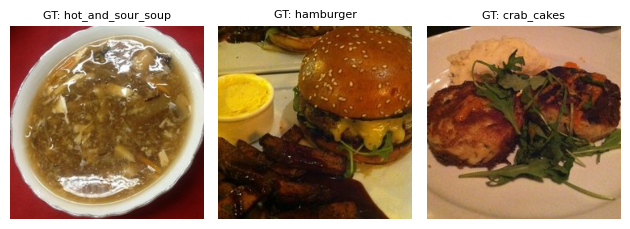

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
n = 3

for i, (data, label) in enumerate(ds_val.take(n)):
    
    plt.subplot(1,n,i+1)
    plt.imshow(data[0].numpy().astype('uint8'))
    plt.title(f"GT: {food_names[label[0].numpy()]}", fontsize = 8)
    plt.axis("off")

plt.tight_layout()
plt.show()

b) Bevor wir mit dem Training beginnen, benötigen wir ein vortrainiertes Modell. Zu diesem Zweck bietet Tensorflow eine Sammlung von auf [ImageNet](http://www.image-net.org/) vortrainierten [Modellen](https://keras.io/api/applications/) an. In der Wahl der Architektur sind Sie frei, allerdings empfiehlt es sich, eine Architektur zu wählen, die einerseits eine hohe Accuracy auf ImageNet hat und andererseits nicht extrem groß ist (z.B. EfficientNetV2 B1).

Laden Sie ein auf ImageNet vortrainiertes Modell und klassifizieren Sie 3 zufällige Beispiele aus den Validierungsdaten von food101. 

Der folgende Code lädt eine Liste der ImageNet-Klassennamen, mit deren Hilfe Sie die Klassennamen aus den Predictions dekodieren können:

4/4 [==============================] - 1s 186ms/step


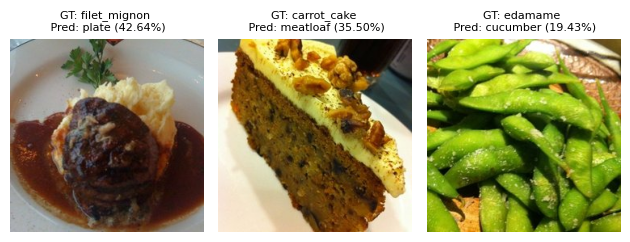

In [32]:
imagenet_model = tf.keras.applications.EfficientNetV2B1(include_top=True, weights="imagenet")

fig = plt.figure()
n = 3

for i, (data, label) in enumerate(ds_val.take(n)):
    #data_batched = np.expand_dims(tf.image.resize(data, (240, 240)), axis=0)
    
    preds = imagenet_model.predict(data)[0]
    
    p = preds.argmax()
    
    plt.subplot(1, n, i+1)
    plt.imshow(data[0].numpy().astype('uint8'))
    plt.title(f"GT: {food_names[label[0].numpy()]} \n Pred: {imagenet_class_names[p]} ({preds[p]:.2%})", fontsize=8)
    plt.axis("off")
    
plt.tight_layout()
plt.show()


c) Führen Sie nun ein Finetuning des vortrainierten Modells auf dem vorgegebenen Food-Datensatz durch. Gehen Sie dazu wie folgt vor:
* Ersetzen Sie die Ausgabeschicht durch eine neue Schicht, die der Anzahl der Klassen des neuen Trainingsdatensatzes entspricht (im Fall von food101 sind das 101).
* Setzten Sie die Schichten des vortrainierten Modells auf nicht trainierbar, sodass nur der hinzugefügte letzte Layer trainiert wird und trainieren Sie das Netz für einige (z.B. 2) Epochen 
* Setzten Sie dann die Schichten (z.B. die letzten 20) des vortrainierten Modells auf trainierbar und trainieren Sie das ganze Netz für mindestens 3 weitere Epochen mit einer niedrigeren Lernrate (z.B. 10x niedriger) 

Die Wahl der Hyperparameter wie Lernrate, Batchgröße, Anzahl der Trainingsepochen, etc. bleibt Ihnen überlassen und ist auch abhängig von der verwendeten Architektur und Gradientenabstiegsverfahren.

Hier einige Hinweise:
* Das Gradientenabstiegsverfahren ADAM mit Lernrate $10^{-3}$ und Standardeinstellungen ist oft eine gute Wahl
* Planen Sie genug Zeit für das Training ein, 10 Epochen sollten Sie mindestens trainieren
* Weitergehende Informationen finden Sie hier: 
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [34]:
# build network architecture

x = inputs = tf.keras.Input(shape=(240, 240, 3))

# data augmentation
x = tf.keras.layers.RandomFlip("horizontal")(x)

model = tf.keras.applications.EfficientNetV2B1(include_top=False, input_tensor=x, weights="imagenet")
model.trainable = False


x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)

outputs = tf.keras.layers.Dense(101, activation="softmax")(x)

food_model = tf.keras.Model(inputs, outputs, name="EfficientNetV2_B1_Food")

#food_model.summary()

In [ ]:
# train last layer

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
food_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

tensorboard_callback = tf.keras.callbacks.TensorBoard(f"{log_folder}/logs/{food_model.name}", histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(f"{log_folder}/checkpoints/{food_model.name}", monitor='val_accuracy', save_best_only=True)

hist = food_model.fit(ds_train, validation_data=ds_val, epochs=2, callbacks=[tensorboard_callback, checkpoint_callback])

In [37]:
# due to shortcut connections in the efficientnet architecture blocks need to be completely freezed or unfreezed

# check block ranges
for i,l in enumerate(food_model.layers):
    print(f"{i}: {l.name}")

In [38]:
print(len(food_model.layers[199:]))

140


In [ ]:
# train last layers (including last block)

## unfreeze last block
for layer in food_model.layers[199:]:
    #lname = layer.name
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        #lname = f"-> {lname}"
        layer.trainable = True
    #print(lname)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
food_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5)

food_model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[tensorboard_callback, checkpoint_callback, lr_callback, early_stopping_callback])

### Loss: (Orange:Train, Grau: Validation)
![epoch_accuracy.svg](epoch_loss.svg)

### Accuracy: (Orange:Train, Grau: Validation)
![epoch_accuracy.svg](epoch_accuracy.svg)

d) Machen Sie ein Foto einer Mahlzeit oder suchen Sie sich ein Bild im Internet. Wenden Sie das von Ihnen trainierte Modell auf das Foto an und visualisieren Sie das Foto und die Top-5 Predictions mit den dazugehörigen Wahrscheinlichkeiten. 

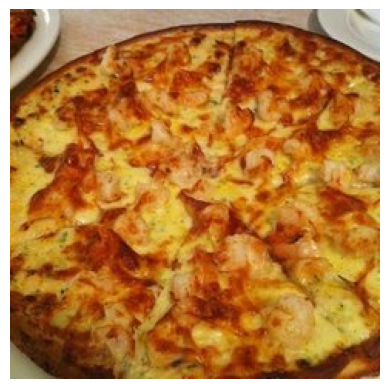

1/1 [==============================] - 1s 1s/step
pizza: 91.33%
garlic_bread: 4.40%
omelette: 3.36%
macaroni_and_cheese: 0.70%
lasagna: 0.13%


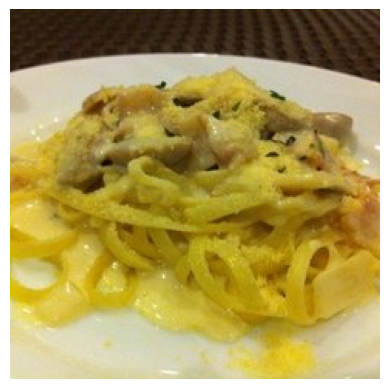

1/1 [==============================] - 0s 46ms/step
spaghetti_carbonara: 99.94%
macaroni_and_cheese: 0.05%
risotto: 0.00%
pad_thai: 0.00%
gnocchi: 0.00%


In [46]:
food_model = tf.keras.models.load_model(f"{log_folder}/checkpoints/{food_model.name}") 

img_paths = ["Pizza.jpg", 
             "Spaghetti.jpg"]

for img_path in img_paths:
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (240, 240))

    plt.imshow(img.numpy().astype('uint8'))
    plt.axis("off")
    plt.show()
    
    img_batched = np.expand_dims(img, axis=0)
    preds = food_model.predict(img_batched)[0]

    for p in (-preds).argsort()[:5]:
        print('{:}: {:.2%}'.format(food_names[p], preds[p]))

---
## **Aufgabe 2: Convolutional Neural Networks (bewertet: 3 Punkte)**

Betrachten Sie ein CNN mit 1-dimensionalem Input. Die Konzepte für den 1-dimensionalen Fall entsprechen denen für zweidimensionale Netze. Daten werden im Netz als 3-dimensionale Arrays interpretiert. Jede Zeile entspricht einer Featuremap, jede Spalte einer Dimension und die Tiefe des Arrays der Batch-Größe. Hier wird allerdings nur ein Eingabevektor betrachtet, die Tiefe ist daher 1.

Das CNN ist folgendermaßen spezifiziert:
- **Input**: Matrix der Größe $1\times12\times1$. Die Eingabe besteht also aus einer einzigen Featuremap mit 12 Dimensionen.
- **Erste Convolutional Layer**: Zwei Filter $F_0^1=(-1,0,1)$ und $F_1^1=(1,0,-1)$ mit Padding = 0 und Schrittweite = 1.
- **Max Pooling Layer** mit Größe = 2 und Schrittweite = 2.
- **Zweite Convolutional Layer**: Filter $F_0^2=((-1,0,1),(1,0,-1))$ mit Padding = 0 und Schrittweite = 1.
- **Vollständig verbundene Schicht (FC)**, die alle Eingaben auf zwei Ausgaben abbildet. Die Gewichte für die erste Ausgabe sind alle -1 und für die zweite Ausgabe alle 1.
- **Sigmoid-Aktivierungsfunktion**

Berechnen Sie die Ausgabe des neuronalen Netzes für den Input (0,0,0,0,1,1,1,1,0,0,0,0):

$\begin{align*}
    (0,0,0,0,1,1,1,1,0,0,0,0) \\
    \Downarrow& \quad Conv 1 \\
    (0,0,1,1,0,0,-1,-1,0,0) \\
    (0,0,-1,-1,0,0,1,1,0,0) \\
    \Downarrow& \quad Pooling \\
    (0,1,0,-1,0)\\
    (0,-1,0,1,0)\\
    \Downarrow& \quad Conv 2 \\
    (0,-4,0)\\
    \Downarrow& \quad FC \\
    (4,-4)\\
    \Downarrow& \quad Sigmoid \\
    (0.98, 0.02)
\end{align*}$